In [24]:
### Run this cell before continuing.
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(broom)

*STAT 201 - GROUP 7*

# Comparing Vehicle Theft Rates in Vancouver, BC. 

Analysis by Soham Chakote, Lisa Desjarlais, Kiersten Lyde-Stad, Hongli Zhang

# Introduction

### Background

Police departments throughout the Lower Mainland and Vancouver Island are becoming increasingly concerned with the rising number of catalytic converter thefts in BC [(Marsten, 2023).](https://vancouver.citynews.ca/2023/01/11/catalytic-converter-theft-saanich/) In 2022, Surrey RCMP noted general thefts from vehicles were up an alarming twenty-two percent [(Moman, 2022).](https://www.surreynowleader.com/news/surrey-seeing-increase-in-catalytic-converter-thefts-police-offer-tips-to-protect-cars/) This rising level of crime in Vancouver has raised concerns over the safety of Vancouverites since weapons are being used to perpetrate these thefts [(VPD, 2021).]( https://vpd.ca/news/2021/10/20/vpd-project-leads-to-catalytic-converter-theft-arrests/) As a result police are warning residents to “be vigilant in where they park their vehicles” [(Marsten, 2023).](https://vancouver.citynews.ca/2023/01/11/catalytic-converter-theft-saanich/) Andresen and Malleson [(2011, as cited in Andresen et al., 2017),](https://doi.org/10.1007/s10940-016-9295-8) found fifty percent of crimes, such as assault, burglary, robbery, sexual assault, theft, and thefts of and from vehicles, over a ten year period were committed in less than nine percent of Vancouver’s streets. Most residents consider areas such as the Central Business District (CBD) and West End a lot safer than others, particularly like Strathcona and Grandview-Woodland. We plan to use statistical inference methods to determine if the proportion of thefts from vehicles does in fact vary significantly between these four districts of Vancouver: the Central business District and West End versus Strathcona and Grandview-Woodland. Because police and analysts are working together to count the number of crimes and find causes, we will use data gathered by the Vancouver Police Department made available for public use on their website. These data sets include statistics on which Vancouver district and date the thefts from vehicles occurred. The significance of collaborative monitoring has become a key element in later explanations of criminal behaviour [(Koop-Monteiro & Yasmin, 2021).](https://doi.org/10.3138/cjccj.2020-0013) 

### Question

### *"Concerning 2018 to 2022, is the proportion of thefts from vehicles in the Strathcona and Grandview-Woodland districts significantly lower than in the West End and Central Business districts of Vancouver, BC.?"*

# Methods & Results

In order to come to a viable conclusion, a hypothesis test must be carried out.

Let ${p_1}$ be the proportion of thefts from vehicles in the Strathcona and Grandview-Woodland districts.

Let ${p_2}$ be the proportion of thefts from vehicles in the West End and Central Business districts.


$H_{o}$ : ${p_1}-{p_2} = 0$


The proportion of thefts from vehicles in the Strathcona and Grandview-Woodland districts **is not significantly lower** than in the West End and Central Business districts of Vancouver, BC, between 2018 to 2022.

$H_{a}$ :   ${p_1}-{p_2} < 0$

The proportion of thefts from vehicles in the Strathcona and Grandview-Woodland districts **is significantly lower** than in the West End and Central Business districts of Vancouver, BC, between 2018 to 2022.

We will be comparing the proportions of these populations using a two-sample z-test:

$Z = \frac{(\hat{p_1}-\hat{p_2})-c}{((\hat{p}(1-\hat{p}))(\frac{1}{n_1}+\frac{1}{n_2}))^{1/2}}$

with $\hat{p}=\frac{n_1\hat{p_1}+n_2\hat{p_2}}{n_1+n_2}$

A **confidence** interval for the true proportion of vehicle thefts in each area group will be constructed via bootstrapping from the samples given by the VPD.

# Read, Clean, & Wrangle

In [25]:
#Set Seed
set.seed(2023)

# Read and Combine CSVS 
# Code from --
# Schork, J (2020). Import & Row-Bind CSV Files in R. https://statisticsglobe.com/merge-csv-files-in-r.
raw_crime <- list.files(path = "data/", 
                       pattern = "*.csv", full.names = TRUE) |>
    lapply(read_csv, show_col_types=FALSE) |>      #Quieted messages                      
    bind_rows() |>
    select(YEAR, NEIGHBOURHOOD, TYPE)



# In order to work with proportions: changing other crime names to "other crime" so there are only two options for crime type.
crime_binary <- raw_crime |>
 mutate(TYPE = recode(TYPE, "Theft from Vehicle" = "theft_from_vehicle", 
                      
"Break and Enter Commercial"                                = "other_crime",
"Break and Enter Residential/Other"                         = "other_crime",
"Vehicle Collision or Pedestrian Struck (with Fatality)"    = "other_crime",
"Vehicle Collision or Pedestrian Struck (with Injury)"      = "other_crime",
"Homicide"                                                  = "other_crime",
"Mischief"                                                  = "other_crime",
"Offence Against a Person"                                  = "other_crime",
"Other Theft"                                               = "other_crime",
"Theft of Vehicle"                                          = "other_crime",
"Theft of Bicycle"                                          = "other_crime"))
                                                        

# merging select districts
crime_combined1 <- crime_binary |>
    filter(NEIGHBOURHOOD %in% c("Central Business District","West End")) |>
    mutate(NEIGHBOURHOOD = "West End & CBD")
crime_combined2 <- crime_binary |>
    filter(NEIGHBOURHOOD %in% c("Strathcona","Grandview-Woodland")) |>
    mutate(NEIGHBOURHOOD = "Strathcona & Grandview-Woodland")
# Combining data sets
crime <- rbind(crime_combined1, crime_combined2)
    
head(crime)


YEAR,NEIGHBOURHOOD,TYPE
<dbl>,<chr>,<chr>
2018,West End & CBD,theft_from_vehicle
2018,West End & CBD,theft_from_vehicle
2018,West End & CBD,theft_from_vehicle
2018,West End & CBD,theft_from_vehicle
2018,West End & CBD,theft_from_vehicle
2018,West End & CBD,theft_from_vehicle


Table 1. *Crime data set consisting of crime statistics in the Central Business District/West End and Strathcona/Grandview-Woodland.*

##### Plot(s)

First we investigate the total thefts from vehicles over five years (2018-2022). Below we can see a spike in thefts in 2019, but a decrease in thefts from 2020 to 2021 and a slight increase in 2022, for our particular districts. This appears to be in opposition to the reported increase in thefts throughout the Lower Mainland and Vancouver Island. However we would need to investigate previous years to gain a better perspective.

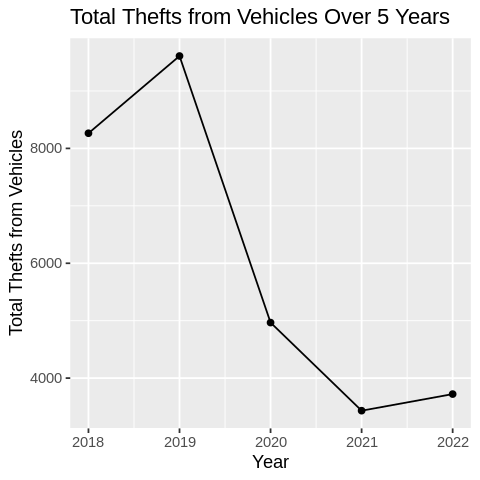

In [26]:
options(repr.plot.width = 4, repr.plot.height = 4)
# Crime Trend Over 5 Years
total_vehicle_theft_trend <- crime |>
    group_by(YEAR) |>
    filter(TYPE == "theft_from_vehicle") |>
    summarize(total_vehicle_theft = n())

total_vehicle_theft_trend_plot <- total_vehicle_theft_trend |>
    ggplot(aes(x = YEAR, y = total_vehicle_theft)) +
    geom_point() +
    geom_line() +
    labs(y = "Total Thefts from Vehicles", x = "Year", title = "Total Thefts from Vehicles Over 5 Years")

total_vehicle_theft_trend_plot

Figure 1. *Theft from vehicle crime trend over 5 years in 4 districts: CBD, West End, Strathcona, Grandview-Woodland.*

Now, we investigate the proportions of thefts for the two regions and visualize our results.

In [27]:
# Determining total number of instances of crime, across all districts
n_all_crimes <- nrow(crime)


# Determining overall proportion of crimes which are vehicle theft, across all districts
overall_v_thefts_prop <- crime |>
    filter(TYPE == "theft_from_vehicle") |>
    summarize(n_overall_v_thefts = n(), 
              n_total_crimes = n_all_crimes,
              prop = n_overall_v_thefts/n_all_crimes)

overall_v_thefts_prop


# Determining proportion of vehicle theft in each district
v_theft_prop <- crime |>
    group_by(NEIGHBOURHOOD) |>
    filter(TYPE == "theft_from_vehicle") |>
    summarize(n_v_thefts = n(),
              prop = n_v_thefts / n_all_crimes)

v_theft_prop

n_overall_v_thefts,n_total_crimes,prop
<int>,<int>,<dbl>
29995,101468,0.2956104


NEIGHBOURHOOD,n_v_thefts,prop
<chr>,<int>,<dbl>
Strathcona & Grandview-Woodland,5755,0.05671739
West End & CBD,24240,0.23889305


Table 2. *Proportion of thefts in CBD/West End verus Strathcona/Grandview-Woodland.*

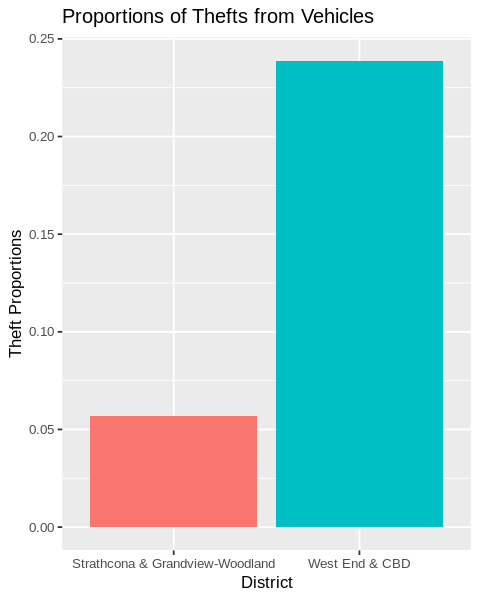

In [28]:
# Plot proportions of thefts from vehicles in CBD/West End verus Strathcona/Grandview-Woodland.

options(repr.plot.width = 4, repr.plot.height = 5)
vehicle_theft_prop_plot <- v_theft_prop|>
    ggplot(aes(x = NEIGHBOURHOOD, y = prop, fill = NEIGHBOURHOOD)) +
    geom_bar(stat = "identity") +
    labs(title = "Proportions of Thefts from Vehicles ", x = "District", y = "Theft Proportions") +
    theme(text = element_text(size = 10), legend.position = "vertical")

vehicle_theft_prop_plot

Figure 2. Plot depicting theft proportions between CBD/West End and Strathcona/Grandview-Woodland (2018-2022).

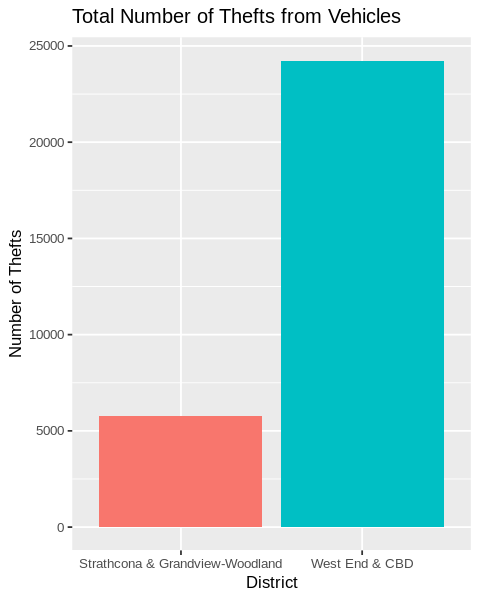

In [29]:
options(repr.plot.width = 4, repr.plot.height = 5)

all_thefts_plot <- crime |>
    filter(TYPE == "theft_from_vehicle") |>
    group_by(NEIGHBOURHOOD) |>
    summarize(n = n()) |>
    ggplot(aes(x = NEIGHBOURHOOD, y = n, fill = NEIGHBOURHOOD)) +
    geom_bar(stat = "identity") +
    labs(title = "Total Number of Thefts from Vehicles", x = "District", y = "Number of Thefts") +
    theme(text = element_text(size = 10), legend.position = "vertical")
    
all_thefts_plot

Figure 3. *Plot depicting total number of vehicle thefts in CBD/West End and Strathcona/Grandview-Woodland (2018-2022).*

It appears that the majority of thefts from vehicles have taken place in the West End and Central Business District. This is not what we expected to find, given Strathcona and Grandview-Woodland's reputation. One possible explanation that may account for these results is population size. According to Hellosafe.ca [(Shepert, 2021),](https://www.vancouverisawesome.com/highlights/bc-ranks-3-in-canada-for-auto-thefts-3435784) the most populated Canadian regions generally have a higher number of auto thefts. 

In [39]:
# Conducting two-sample z-test:

sample1 <- crime |>
filter(NEIGHBOURHOOD == "Strathcona & Grandview-Woodland")

n1 <- nrow(sample1)

p1 <- mean(sample1$TYPE == "theft_from_vehicle")

sample2 <- crime |>
filter(NEIGHBOURHOOD == "West End & CBD")

n2 <- nrow(sample2)

p2 <- mean(sample2$TYPE == "theft_from_vehicle")

phat <- (p1*n1 + p2*n2) / (n1 + n2)

z_score <- (p1-p2) / (sqrt (phat * (1 - phat)) * ((1/n1) + (1/n2)) )

p_value <- pt(z_score, 
              df = nrow(crime) - 1 , 
              lower.tail  = TRUE)

prop_test <- tidy(
    prop.test(x = c(sum(sample1$TYPE == "theft_from_vehicle"), sum(sample2$TYPE == "theft_from_vehicle")),
              n = c(n1, n2),
              alternative = c("less"),
              correct = FALSE))

prop_test

    

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.2382135,0.3135469,501.6753,2.05316e-111,1,-1,-0.07005566,2-sample test for equality of proportions without continuity correction,less


stat
<dbl>
0.07533343


lower_ci,upper_ci
<dbl>,<dbl>
-0.006489285,0.004601684


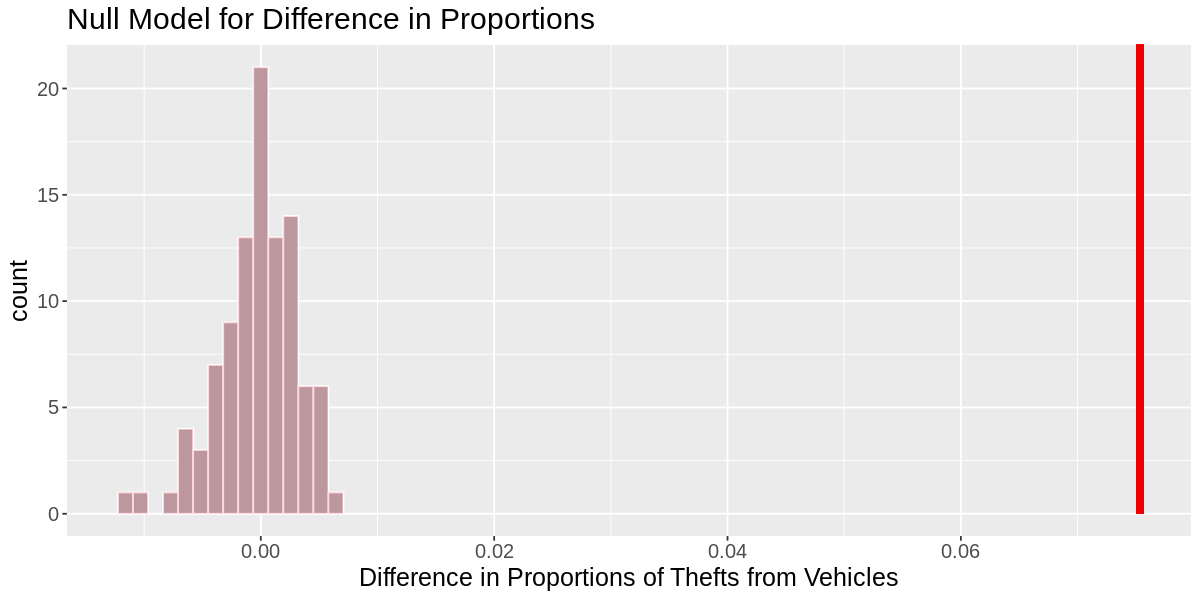

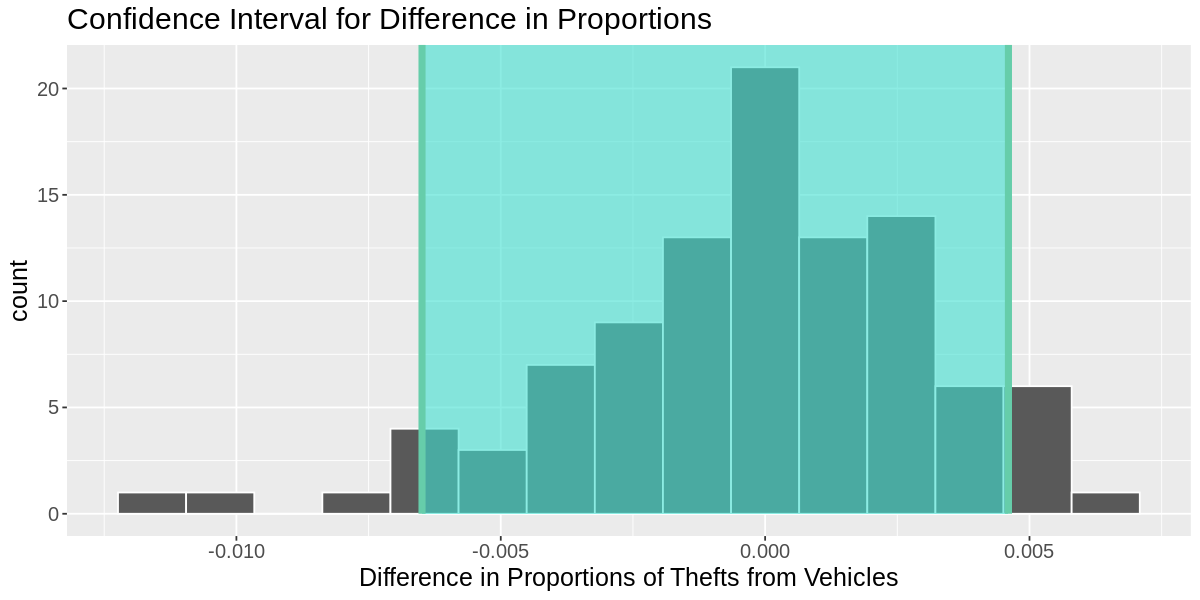

In [33]:
options(repr.plot.width = 10, repr.plot.height = 5)  

# Constructing bootstrap confidence interval

diff_props_observed <-  crime |>
specify(TYPE ~ NEIGHBOURHOOD, success = "theft_from_vehicle") |>
calculate(stat = "diff in props", c("West End & CBD", "Strathcona & Grandview-Woodland"))

diff_props_observed

# Creating bootstrapping distribution
diff_props_btsp <- crime |>
specify(TYPE ~ NEIGHBOURHOOD, success = "theft_from_vehicle") |>
hypothesize(null = "independence") |>
generate(reps = 100, type = "bootstrap") |>
calculate(stat = "diff in props", order = c("West End & CBD", "Strathcona & Grandview-Woodland"))

# Creating null distribution
diff_props_null <- crime |>
specify(TYPE ~ NEIGHBOURHOOD, success = "theft_from_vehicle") |>
hypothesize(null = "independence") |>
generate(reps = 100, type = "permute", size = 100) |>
calculate(stat = "diff in props", order = c("West End & CBD", "Strathcona & Grandview-Woodland"))

# Plotting null model with p-value
diff_props_null_plot <- diff_props_null |>
visualize() +
shade_p_value(obs_stat = diff_props_observed, direction = "left") +
xlab("Difference in Proportions of Thefts from Vehicles") + 
theme(text = element_text(size = 15)) + 
ggtitle("Null Model for Difference in Proportions")

diff_props_null_plot

diff_in_props_ci <- diff_props_null |>
summarize(lower_ci = quantile(stat, 0.05), upper_ci = quantile(stat, 0.95))

diff_in_props_ci

# Plotting bootstrap confidence interval
diff_in_props_ci_plot <- diff_props_null |>
visualize() +
shade_ci(endpoints = diff_in_props_ci) + 
xlab("Difference in Proportions of Thefts from Vehicles") +
theme(text = element_text(size = 15)) + 
ggtitle("Confidence Interval for Difference in Proportions")

diff_in_props_ci_plot

In [35]:
point_estimates <- diff_props_btsp |>
                   group_by(NEIGHBOURHOOD) |>
                   summarise(mean_prop = mean(prop))
point_estimates

ERROR: [1m[33mError[39m in [1m[1m`group_by()`:[22m
[1m[22m[33m![39m Must group by variables found in `.data`.
[31m✖[39m Column `NEIGHBOURHOOD` is not found.


Table 4. *Point estimates of Strathcona/Grandview-Woodland and West End/CBD proportions.*

In [36]:
# Calculate the observed difference in proportion
p_diff <- point_estimates$mean_prop[1] - point_estimates$mean_prop[2]
# Calculate the sample standard error of the difference in proportions
n1 <- nrow(crime_bootstrap %>% filter(NEIGHBOURHOOD == "Strathcona & Grandview-Woodland"))
n2 <- nrow(crime_bootstrap %>% filter(NEIGHBOURHOOD == "West End & CBD"))
p1 <- point_estimates$mean_prop[1]
p2 <- point_estimates$mean_prop[2]
p_diff_std_error <- sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)

# Combine results into a data frame
combined_df <- point_estimates |>
    mutate(p_diff = p_diff, p_diff_std_error = p_diff_std_error)

combined_df

ERROR: Error in eval(expr, envir, enclos): object 'point_estimates' not found


Table 5. The difference and standard error in proportion

In [37]:
combined_df <- 
    combined_df %>% 
    mutate(lower_ci = qnorm(0.025, p_diff, p_diff_std_error),
    upper_ci = qnorm(0.975, p_diff, p_diff_std_error)
)
combined_df

ERROR: Error in mutate(., lower_ci = qnorm(0.025, p_diff, p_diff_std_error), : object 'combined_df' not found


Table 6. The 95% confidence interval for the difference in proportion

# Discussion

* Evaluation of the results

Baesd on the P value existed above which is nearly zero, we can generally conclude that there is strong evidence against the null hypothesis(The proportion of thefts from vehicles in the Strathcona and Grandview-Woodland districts is not significantly lower than in the West End and Central Business districts of Vancouver, BC, between 2018 to 2022) and that the alternative hypothesis is more likely to be true.Facts have proved that in the same city, both the economically developed city center and the more chaotic areas are facing serious vehicle theft. The same goes for the Surrey region mentioned in the introductory section. The phenomenon of criminal theft in cities is closely related to people's daily life. Stolen vehicles will cause more crimes and affect the owner's property and travel. In the CBD and west end areas, patrols should be strengthened and publicity and warnings should be carried out.

* The implications/impact of our findings

From our data analysis, we can clearly conclude that the vehicle theft records in the CBD and west end areas are much higher than those in Strathcona and Grandview-Woodland areas. In the comparison of these two areas, nearly 4/5 of the vehicle theft crimes are in the more prosperous CBD and west end areas rather than the chaotic East Vancouver area. This is due to the good economic conditions and more car ownership in the CBD and west end areas. First, when an area has a good economy, more people can afford to buy a car, which means more cars on the road and therefore more opportunities to steal them. Also, in a strong economy, car owners may prefer to own newer, more expensive cars, which are more attractive to thieves. Secondly, with more and more expensive metal car equipment, thieves are more willing to steal cars with higher value and expensive personal items such as computers and bags placed inside the car for sale. Usually, cars that are stolen for financial gain are linked to organized adult offenders who are part of a criminal network. (Dhami, 2008) The more active population flow in the CBD and west end areas gives teenagers more opportunities to commit vehicle theft without being easily detected. Since the end of 2019, the global covid-19 epidemic has caused most of the schools to switch to online classes, so teenagers have more time to commit vehicle theft. In the context of the global epidemic, the unemployment rate of Canada's working-age population over the age of 15 has reached nearly 1/10 in September 2020 statistics. (McIntyre&Lee, 2020) The unemployment and life pressure of many people force these people to take risks and choose crimes to maintain their lives and escape social reality. But it is worth noting that the crime of car theft after 2020 has even decreased compared to before 2020, thanks to advanced car anti-theft systems that make it more difficult for unattended cars to go undetected "Missing".

# References

Andresen, M. A., Linning, S. J., & Malleson, N. (2017). Crime at places and spatial concentrations: Exploring the spatial stability of property crime in Vancouver BC, 2003–2013. *Journal of Quantitative Criminology,* 33(2), 255-275. https://doi.org/10.1007/s10940-016-9295-8

Andresen, M. A., & Malleson, N. (2011). Testing the stability of crime patterns: Implications for theory and policy. *The Journal of Research in Crime and Delinquency,* 48(1), 58-82. https://doi.org/10.1177/0022427810384136


Dhami, M.K. (2008). Youth Auto Theft: A Survey of a General Population of Canadian Youth. Canadian Journal of Criminology and Criminal Justice 50(2), 187-209. https://www.muse.jhu.edu/article/242411.

Koop-Monteiro, Yasmin. “The Social Organization of Community-Run Place: An Analysis of Community Gardens and Crime in Vancouver (2005–2015).” *Canadian Journal of Criminology and Criminal Justice,* 63, no. 1 (2021): 23–51. https://doi.org/10.3138/cjccj.2020-0013.

Marsten, E. (2023, January 11). *B.C. police agencies warn of catalytic converter thefts.* City News Everywhere. https://vancouver.citynews.ca/2023/01/11/catalytic-converter-theft-saanich/

McIntyre, R. S., & Lee, Y. (2020). Projected increases in suicide in canada as a consequence of COVID-19. Psychiatry Research, 290, 113104-113104. https://doi.org/10.1016/j.psychres.2020.113104

Moman, S. (2022, August 26). Surrey seeing increase in catalytic converter thefts, police offer tips to protect cars. *Surrey Now-Leader.* https://www.surreynowleader.com/news/surrey-seeing-increase-in-catalytic-converter-thefts-police-offer-tips-to-protect-cars/

PRIME BC Police Records Management System (RMS). *Crime Data Download*. Accessed March 2023. https://geodash.vpd.ca/opendata/

Schork, J (2020). Import & Row-Bind CSV Files in R. https://statisticsglobe.com/merge-csv-files-in-r.

Shepert, E. (2021, Feburary 17). *B.C. ranks #3 in Canada for auto thefts.* Vancouver is Awesome. https://www.vancouverisawesome.com/highlights/bc-ranks-3-in-canada-for-auto-thefts-3435784 

Vancouver Police Department. (2021, October 20). VPD project leads to catalytic converter theft arrests [Press Release]. https://vpd.ca/news/2021/10/20/vpd-project-leads-to-catalytic-converter-theft-arrests/
